In [37]:
%matplotlib inline
import numpy as np
import math
import warnings
from skimage import io
from pylab import *
from matplotlib import pylab as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import imshow
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pydicom

warnings.simplefilter("ignore")

In [38]:
def bresenham(x1, y1, x2, y2):
    x = x1
    y = y1
    points = []
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2

    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y1

    points.append([x,y])
    
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                x += xi
                d += bi
            points.append([x,y])
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                y += yi
                d += bi
            points.append([x,y])

    return points

In [39]:
def sum_points(points, img):
    sumOfPoints = 0.0
    for point in points:
        sumOfPoints += img[point[0],point[1]]
    return sumOfPoints

In [40]:
def coordToCart(angle, cx, cy, radius):
    x = int(math.cos(math.radians(angle)) * radius) + cx
    y = int(math.sin(math.radians(angle)) * radius) + cy
    return x,y

In [50]:
def filterKernel(size):
    img = np.zeros(size)
    center = int(size/2)
    img[center] = 1.0
    for i in range(center+1, len(img)):
        dist = i-center
        if dist % 2 == 0:
            img[i] = 0.0
            img[center-dist] = 0.0
        else:
            img[i] = (-4/math.pow(math.pi,2))/math.pow(i,2)
            img[center-dist] = (-4/math.pow(math.pi,2))/math.pow(i,2)
            
    return img


[-0.00206778  0.         -0.00281448  0.         -0.00405285  0.
 -0.00633257  1.         -0.00633257  0.         -0.00405285  0.
 -0.00281448  0.         -0.00206778]


In [51]:
def doTomography(img, emiterAngles, inc_angle, emiterRange=60.0, detectors=201, withFilter=True):
    # Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
    beta = emiterRange*2
    emiters = img.copy()
    img_size = img.shape[0]
    centre = int(img_size/2)
    radius = centre-5
    
    if (detectors % 2 != 1):
        detectors += 1
    
    if withFilter:
        splotFunc = filterKernel(detectors)
    sinogram = np.zeros((len(emiterAngles),detectors))

    #petla - kazda pozycja emitera
    for angle in emiterAngles:
        emiter_x, emiter_y = coordToCart(angle, centre, centre, radius)
        emiters[emiter_y, emiter_x] = 255
    
        sin_results = np.zeros(detectors)
        #petla - kazda pozycja detektora
        
        for a in range(detectors):
            alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
            detx, dety = coordToCart(alfa, centre, centre, radius)
            
            if dety < emiter_y:
                points = bresenham(detx, dety, emiter_x, emiter_y)
            else:
                points = bresenham(emiter_x, emiter_y, detx, dety)
            
            #sinogram[int(angle/inc_angle),a] = sum_points(points, img)
            sin_results[a] = sum_points(points, img)
        
        if withFilter:
            sinogram[int(angle/inc_angle),:] = np.convolve(sin_results, splotFunc, 'same')
        else:
            sinogram[int(angle/inc_angle),:] = sin_results
        
    return emiters, sinogram



def createOffset(img, offset=2):
    square_size = img.shape[0]
    side = int((int(square_size*offset) - square_size)/2)
    image = np.zeros((int(square_size*offset),int(square_size*offset)))
    for i in range(square_size):
        for j in range(square_size):
            image[i+side,j+side]= img[i,j]
    return image

def delOffset(img, offset=2):
    img_size = img.shape[0]
    new_size = int((img_size/offset))
    side = int((img_size-new_size)/2)
    image = np.zeros((new_size,new_size))
    image[:,:] = img[side:side+new_size, side:side+new_size]
    return image 

def createSquare(square_size=500):
    square = 255*np.ones((square_size,square_size), dtype=np.float64)
    return square

def normalize(img):
    min_value = np.min(img)
    max_value = np.max(img)
    for i in range(len(img)):
        for j in range(len(img[i])):
            img[i,j]=(img[i,j] - min_value)/(max_value-min_value) *255
            
    return img

In [43]:
def meanError(imgIn, imgOut):
    if imgIn.shape!=imgOut.shape:
        return 0
    error = np.zeros(imgIn.shape[0])
    
    for i in range(imgIn.shape[0]):
        error[i] = mean_squared_error(imgIn[i], imgOut[i])
    
    return error


In [53]:

def doInvTomography(sinogram, img_size, emiterAngles, inc_angle, emiterRange=60.0, detectors=201):
    # Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
    beta = emiterRange*2
    centre = int(img_size/2)
    radius = centre-5
    #print(sinogram)
    img = np.zeros((img_size, img_size))
    
    if (detectors % 2 != 1):
        detectors += 1

    #petla - kazda pozycja emitera
    for angle in emiterAngles:
        emiter_x, emiter_y = coordToCart(angle, centre, centre, radius)
        

        #petla - kazda pozycja detektora
        for a in range(detectors):
            alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
            detx, dety = coordToCart(alfa, centre, centre, radius)
            #image[detx,dety] = 155
            if dety < emiter_y:
                points = bresenham(detx, dety, emiter_x, emiter_y)
            else:
                points = bresenham(emiter_x, emiter_y, detx, dety)

            for point in points:
                img[point[0], point[1]] += int(sinogram[int(angle/inc_angle), a])

    return img

def main(file='square', square_size=500, offset=2, 
         inc_angle=0.5, emiterRange=60.0, detectors=201, withOffset = True, withFilter = True):
    if file != 'square':
        img = mpimg.imread(file)
    else:
        img = createSquare(square_size)
    
    #obrazek wyjsciowy z offsetem
    fig = figure(figsize=(80,40))
    if withOffset:
        imgWithOffset = createOffset(img, offset)
    else:
        imgWithOffset = img
    subplot(4,1,1)
    imshow(imgWithOffset, cmap='gray')
    imgSize = imgWithOffset.shape[0]
    
    #sinogram
    emiterAngles = np.linspace(0, 360, 360/inc_angle, endpoint=False)
    emiters, sinogram = doTomography(imgWithOffset, emiterAngles, inc_angle, emiterRange, detectors, withFilter)
    subplot(4,1,2)
    imshow(sinogram, cmap='gray')
    
    
    #obrazem z sinogramu
    imgFromSinogram = doInvTomography(sinogram, imgSize, emiterAngles, inc_angle, emiterRange, detectors)
    subplot(4,1,3)
    imshow(imgFromSinogram, cmap='gray')
    
    #obciecie offsetu
    if withOffset:
        imgToCompare = delOffset(imgFromSinogram, offset)
    else:
        imgToCompare = imgFromSinogram
        
    normalized_image = normalize(imgToCompare)
    subplot(4,1,4)
    imshow(normalized_image, cmap='gray')
    print(meanErrorIter(img, normalized_image))
    print(mean_squared_error(img, normalized_image))

[ 4107.7985597   4336.40248542  4610.26270514  4858.95974249
  5168.05803861  5509.7281803   5857.22291097  6285.83024752
  6521.57399682  7031.75963212  7597.41813333  6324.6543422
  6272.9128809   6168.3042343   6019.85995229  5857.04570635
  5767.80076342  5422.92433996  5500.92837015  5358.54285761
  6084.18414191  6449.94517102  6679.38616617  7015.49828257
  7081.01240832  7227.98936315  7502.63895588  7501.13998792
  7772.81589776  7569.75586836  7897.37275336  7916.94611335
  7976.47559429  8154.42441696  8109.78698605  8328.29383172
  8265.31695267  8546.98885345  8482.84877045  8700.81776276
  8671.70625806  8667.34027989  8951.83292597  9031.23480597
  9046.75971467  9222.14902619  9240.54831103  9461.40384294
  9493.29929084  9464.53998321  9685.79670509  9683.50109834
  9870.98604783  9970.48013612  9668.70331214  9587.26697008
  9540.82747923  9508.94952335  9511.36932075  9498.4323557
  9547.14144802  9445.4720354   9624.82472099  9607.58422424
  9524.8712477   9496.1271

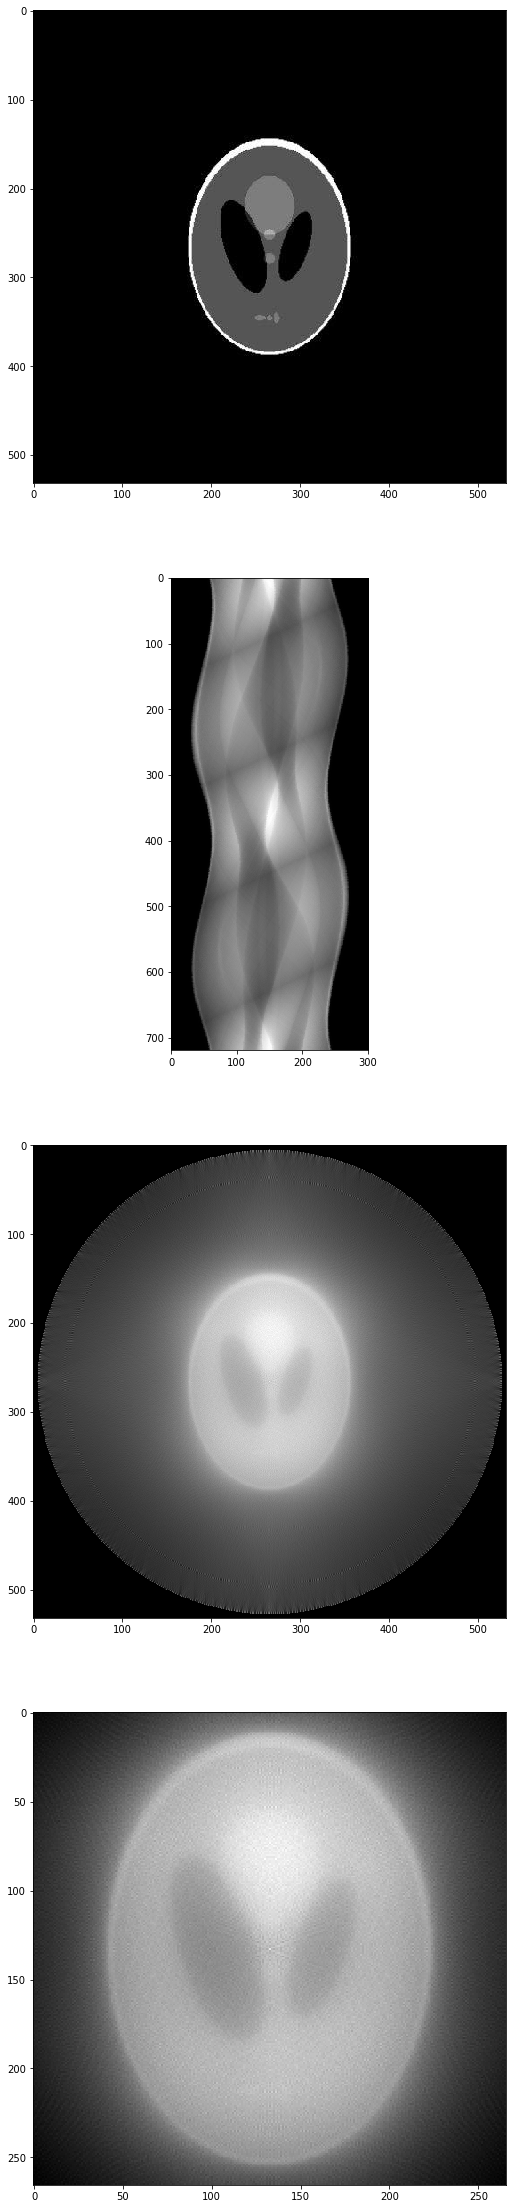

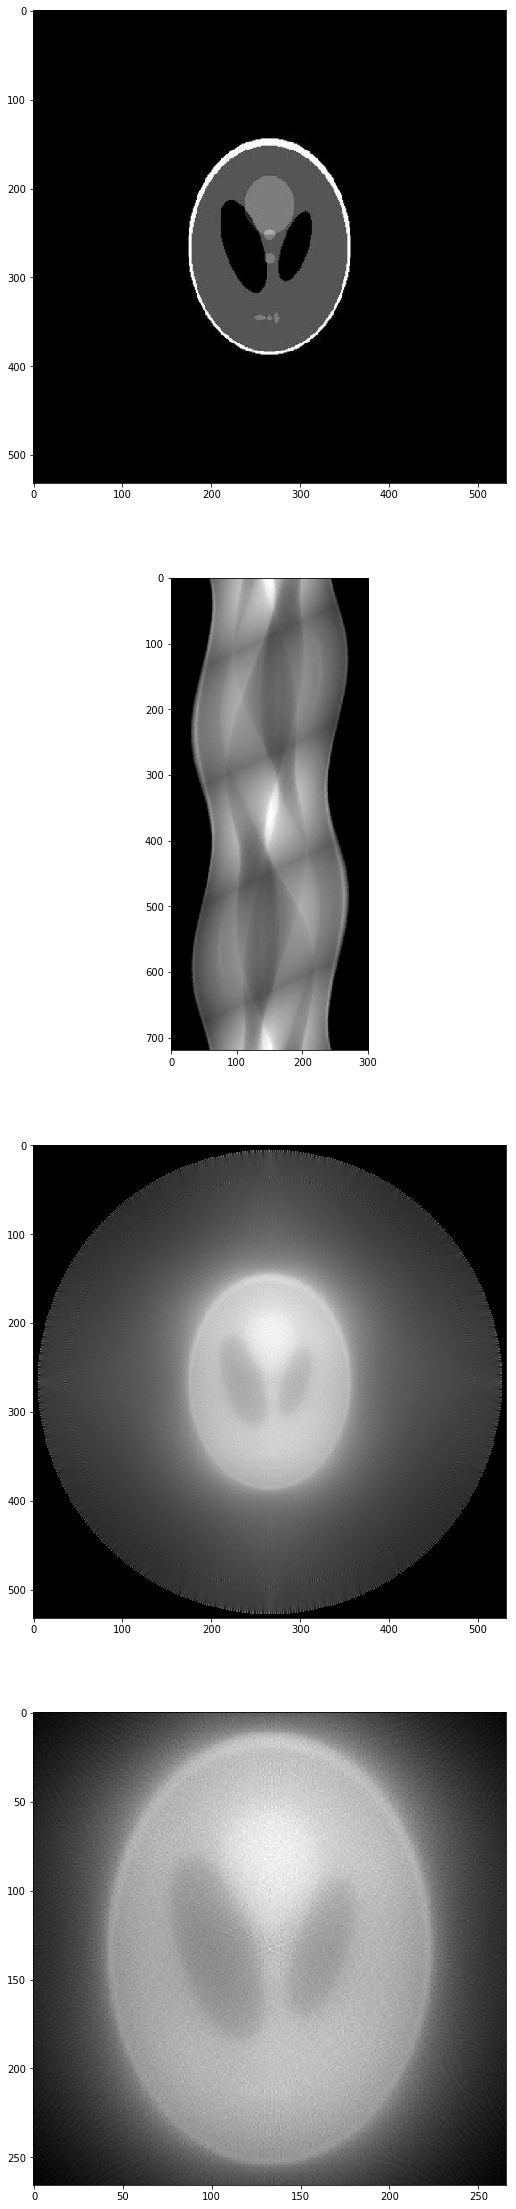

In [54]:
main(file='ph.jpg', emiterRange=70.0, detectors=301)
main(file='ph.jpg', emiterRange=70.0, detectors=301, withFilter=False)